In [1]:
import sys
sys.path.append('../scripts/')
sys.path.append('../models/')

from data import Dataset
from sc_ged import SC_GED
from sc_sum import SC_SUM
from sc_al import SC_AL
from k_kmeans import K_KMEANS
from utils import modularity

import numpy as np
import pandas as pd

from utils import dispaly_results, evaluation_pipeline

import time

%reload_ext autoreload
%autoreload 2

In [2]:
dataset_names = ["Cora", "AUCS", "MIT"]
datasets = [Dataset(name) for name in dataset_names]
model_names = ["SC_SUM", "SC_AL", "K_KMEANS", "SC_GED"]
metric_names = ["purity", "nmi", "ri", "time"]

results = pd.DataFrame(columns=pd.MultiIndex.from_product([model_names, metric_names]), index=dataset_names)
results


SC_SUM                 SC_AL                K_KMEANS                 \
     purity  nmi   ri time purity  nmi   ri time   purity  nmi   ri time   
Cora    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN   
AUCS    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN   
MIT     NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN   

     SC_GED                 
     purity  nmi   ri time  
Cora    NaN  NaN  NaN  NaN  
AUCS    NaN  NaN  NaN  NaN  
MIT     NaN  NaN  NaN  NaN

In [3]:
most_informative_layer = {
    "Cora": 2,
    "AUCS": 1,
    "MIT": 0
}

for dataset, dataset_name in zip(datasets, dataset_names):
    for model_name in model_names:
        k = np.unique(dataset.labels).shape[0]
        if model_name == "SC_GED":
            most_informative = most_informative_layer[dataset_name]
            model = SC_GED(dataset.MLG, k, most_informative=most_informative, alpha=0.5, beta=10)
        elif model_name == "SC_SUM":
            model = SC_SUM(dataset.MLG, k)
        elif model_name == "SC_AL":
            model = SC_AL(dataset.MLG, k)
        elif model_name == "K_KMEANS":
            model = K_KMEANS(dataset.MLG, k)

        start_time = time.time()
        purity, nmi, ri = evaluation_pipeline(dataset, model)
        end_time = time.time()
        elapsed_time = end_time - start_time

        results.loc[dataset_name, (model_name, "purity")] = purity
        results.loc[dataset_name, (model_name, "nmi")] = nmi
        results.loc[dataset_name, (model_name, "ri")] = ri
        results.loc[dataset_name, (model_name, "time")] = elapsed_time
# results.to_csv("../results/cora1aucs0mit2.csv")

Joint Eigen Decomposition: 100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


Joint Eigen Decomposition: 100%|██████████| 60/60 [00:07<00:00,  8.57it/s]


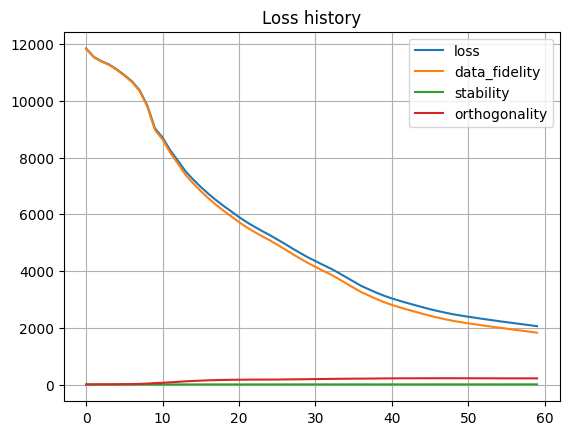

In [37]:
model = SC_GED(datasets[2].MLG, 7, most_informative=2, alpha=0.5, beta=10)
model.fit(n_iter=60)
model.plot_loss()

In [38]:
model.evaluate(datasets[2].labels)

(0.5777777777777777, 0.3199376992816898, 0.6387016229712859)

In [39]:
k = np.unique(datasets[1].labels).shape[0]
model = SC_GED(datasets[1].MLG, k, most_informative=0, alpha=0.5, beta=10)
model.fit()
clustering = model.clustering
for layer, G in zip(datasets[1].layer_labels, datasets[1].MLG):
    m = modularity(G, clustering)
    print(f"Modularity of layer based on clustering {layer}: {m:.4f}")

Joint Eigen Decomposition: 100%|██████████| 40/40 [00:01<00:00, 23.75it/s]


Modularity of layer based on clustering lunch: 0.5997
Modularity of layer based on clustering facebook: 0.2721
Modularity of layer based on clustering leisure: 0.4740
Modularity of layer based on clustering work: 0.4000
Modularity of layer based on clustering coauthor: 0.6621


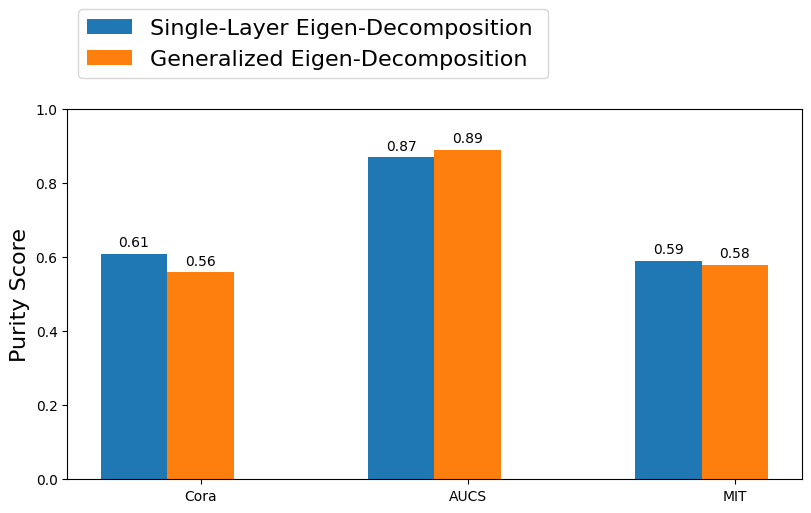

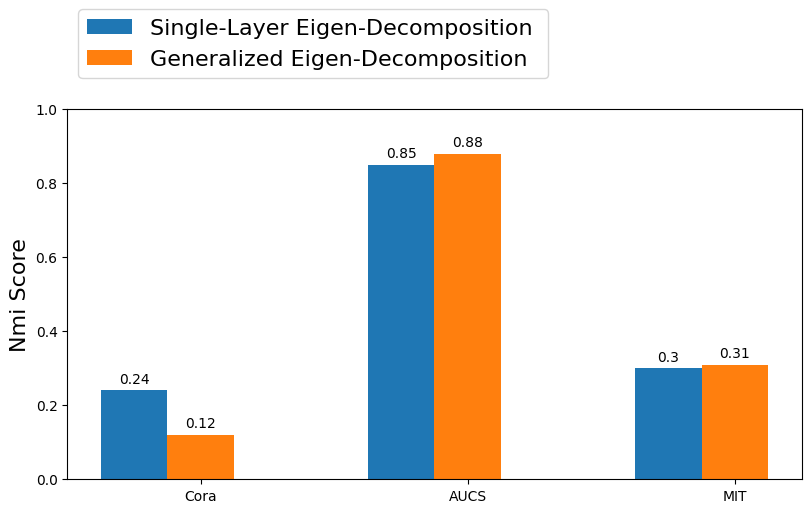

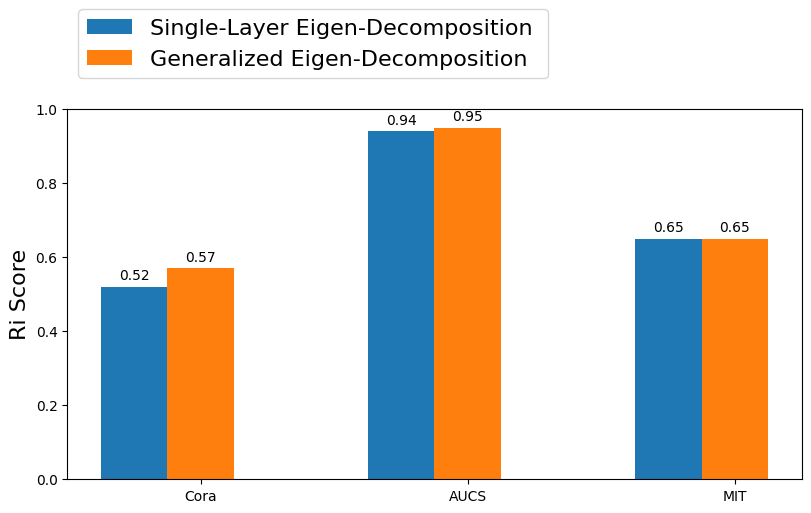

In [41]:
results = pd.read_csv('../results/cora1aucs0mit2.csv', index_col=0, header=[0,1])
dispaly_results(results)